In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from csv import writer
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Reshape, Dense, BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from model import *
from utils import *

In [3]:
N_EPOCHS = 30
BATCH_SIZE = 128

# depth of the lob
DEPTH = 10

# size of the time-series slice used as input to the NN
WINDOW_SIZE = 100

# offset for the rolling windows used for training
OFFSET = 1

# size of the smoothing kernel used to generate labels
KERNEL_SIZE = 50

# labels are quantized into -1, 0, 1 based on this threshold
LABEL_THRESHOLD = 2e-5
N_FEATURES = 1

In [4]:
keys, bpcs, apcs, bvcs, avcs = get_keys(DEPTH)

# Data

In [5]:
df = pd.read_csv('_input/data/20210714_182011.csv')[:4000]
df.index = pd.to_datetime(df['timestamp'] * 1000 * 1000)
assert df.index.is_unique

In [6]:
df = prepare_features(df)
df = prepare_labels(df, kernel_size=KERNEL_SIZE)

/Users/konstantinisstarovoitovs/projects/deribot/utils.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, data.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)
/Users/konstantinisstarovoitovs/projects/deribot/utils.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, data.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)
/Users/konstantinisstarovoitovs/projects/deribot/utils.py:

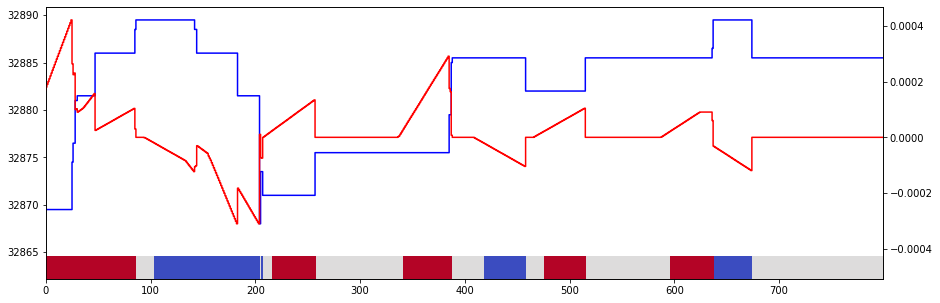

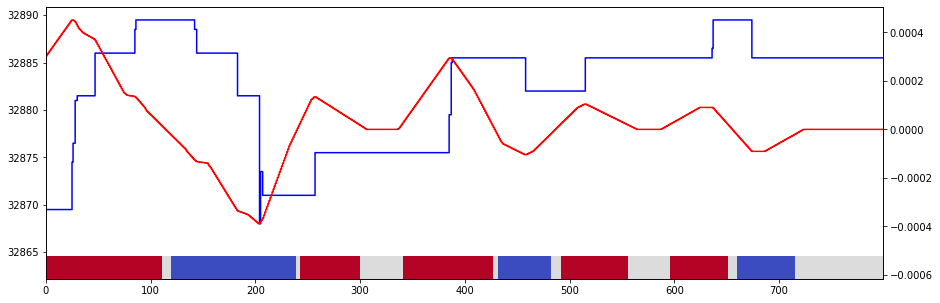

In [7]:
N0, N1 = 0, 800

for label in 'y1', 'y2':

    plt.figure(figsize=(15, 5))

    # colors
    cs = -1 + 1. * (df.iloc[N0:N1][label] > -LABEL_THRESHOLD) + 1. * (df.iloc[N0:N1][label] > LABEL_THRESHOLD)

    # price
    plt.step(np.arange(N1-N0), df.iloc[N0:N1]['best_bid_price'], c='b')
    add_pcolor_to_plot(plt.gca(), cs)

    # label
    plt.twinx().step(np.arange(N1-N0), df.iloc[N0:N1][label], c='r')
    add_pcolor_to_plot(plt.gca(), cs)

(array([ 731.,    0.,    0.,    0.,    0., 2230.,    0.,    0.,    0.,
         841.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

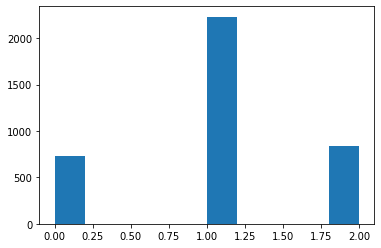

In [8]:
X1, X2 = split_x(df, offset=OFFSET, window_size=WINDOW_SIZE)
y = split_y(df, OFFSET, WINDOW_SIZE)
plt.hist(np.argmax(y, axis=1))

In [9]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.15, shuffle=False)

# Build model

In [13]:
model_name = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
model = build_model(window_size=WINDOW_SIZE, n_features=N_FEATURES, depth=DEPTH)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 40, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 100, 20, 16)  48          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 100, 20, 16)  1040        conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 100, 20, 16)  1040        conv2d_10[0][0]                  
____________________________________________________________________________________________

In [ ]:
cp_callback = ModelCheckpoint(filepath=f'_output/models/{model_name}.h5', monitor='val_accuracy', save_weights_only=True, save_best_only=True)
history = model.fit([X1_train, X2_train], y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.15, callbacks=[cp_callback], verbose=2)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [12]:
# load and evaluate best model

model.load_weights(f'_output/models/{model_name}.h5')

loss, accuracy = model.evaluate([X1_test, X2_test], y_test, verbose=0)

print(f"{'loss':15}{loss:7.4f}")
print(f"{'accuracy':15}{accuracy:7.4f}")

y_pred_num = np.argmax(model.predict([X1_test, X2_test]), axis=1)
y_test_num = np.argmax(y_test, axis=1)

precision, recall, fscore, support = precision_recall_fscore_support(y_pred_num, y_test_num)

print(f"{'precision':15}{' '.join(['{:7.2f}'.format(x) for x in precision])}")
print(f"{'recall':15}{' '.join(['{:7.2f}'.format(x) for x in recall])}")
print(f"{'fscore':15}{' '.join(['{:7.2f}'.format(x) for x in fscore])}")
print(f"{'support':15}{' '.join(['{:7}'.format(x) for x in support])}")


OSError: Unable to open file (unable to open file: name = '_output/models/20210729_155247.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)